In [ ]:
import pandas as pd
import pandas as pd
%pip install sqlalchemy pymysql
from sqlalchemy import create_engine
import numpy as np
%pip install openpyxl
import openpyxl

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
def get_data_feed_public(query):
    username = 'tom'
    password = 'tom1234!'
    host = 'database-1.cmy0wo2batmu.ap-southeast-2.rds.amazonaws.com'
    port = '3306'
    schema = 'Feed_Public'
    
    connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/{schema}'
    engine = create_engine(connection_string)
    return pd.read_sql(query, engine)


In [ ]:
def score_posts_for_date(feed_new, feed_extra):
    """
    Takes feed_new, feed_extra for a specific date.
    Returns a DataFrame of scored posts for that date.
    """

    # Define score mappings
    score_maps = {
        'cash_flow_and_financing': {'Weak': 0, 'OK': 1, 'Supported': 2, 'Strengthening': 3, 'Strong': 4},
        'cost_management': {'Reducing': 0, 'Efficient': 1, 'Strategic': 2},
        'operational_milestones': {'Mixed': 0, 'Continuing': 1, 'Expanding': 2},
        'partnership_and_strategic_initiatives': {'Initiating': 0, 'Steady': 1, 'Expanding': 2},
        'project_development': {'Mixed': 0, 'Initiating': 1, 'Progressing': 2},
        'revenue_and_profitability': {'Downturn': 0, 'Stable': 1, 'Potential': 2, 'Growth': 3}
    }

    # Keep only relevant cols
    feed_extra = feed_extra[['feed_id', *score_maps.keys()]].copy()

    # Map text values to numerical scores
    for col, mapping in score_maps.items():
        feed_extra[col] = feed_extra[col].map(mapping)

    # Drop rows with no health metrics at all
    feed_extra.dropna(subset=list(score_maps.keys()), how='all', inplace=True)

    # Merge with feed_new (for date + primary_stock)
    feed_extra = feed_extra.merge(
        feed_new[['feed_id', 'primary_stock', 'date']],
        on='feed_id', how='left'
    )
    feed_extra.dropna(subset=['primary_stock'], inplace=True)

    # Calculate health score
    feed_extra['health_score'] = feed_extra[list(score_maps.keys())].sum(axis=1)

    return feed_extra


In [ ]:
print(historical)

In [37]:
from datetime import datetime, timedelta
import pandas as pd

start_date = datetime(2025, 4, 7)
end_date = datetime(2025, 4, 11)

daily_scored_dfs = {}

current = start_date
while current <= end_date:
    date_str = current.strftime('%Y-%m-%d')
    print(f"Processing {date_str}...")

    try:
        # Get daily data
        feed_new = get_data_feed_public(f"SELECT * FROM feed_new WHERE date = '{date_str}'")
        if feed_new.empty:
            current += timedelta(days=1)
            continue

        feed_extra = get_data_feed_public("SELECT * FROM feed_extra")

        # Score posts using the function
        scored_df = score_posts_for_date(feed_new, feed_extra)

        if not scored_df.empty:
            daily_scored_dfs[date_str] = scored_df

    except Exception as e:
        print(f"Failed on {date_str}: {e}")

    current += timedelta(days=1)


Processing 2025-04-07...
Processing 2025-04-08...
Processing 2025-04-09...
Processing 2025-04-10...
Processing 2025-04-11...


In [38]:
counts = []

for day in daily_scored_dfs.keys():
    print(day)
    rows = len(daily_scored_dfs[day])
    print(rows)
    counts.append(rows)

print(np.array(counts).mean())


2025-04-07
270
2025-04-08
256
2025-04-09
88
2025-04-10
267
2025-04-11
193
214.8


In [39]:
all_scored_df = pd.concat(daily_scored_dfs.values(), ignore_index=True)

In [ ]:
import numpy as np
def get_dynamic_threshold(
    historical_scores,
    approved_count,
    rejected_count,
    max_posts=50,
    max_potential_posts=500
):
    """
    Returns the dynamic threshold needed to approve a post, based on:
    - how many approvals are still available
    - how many posts are expected to still come
    - distribution of scores seen so far

    Assumes historical_scores are all prospective post scores seen today.
    """

    if approved_count >= max_posts:
        return float('inf')

    posts_seen = approved_count + rejected_count
    posts_remaining = max_potential_posts - posts_seen
    approvals_remaining = max_posts - approved_count

    if posts_remaining <= 0:
        return float('inf')

    required_percentile = 100 * (1 - approvals_remaining / posts_remaining)
    return np.percentile(historical_scores, required_percentile, interpolation ='linear')


In [41]:


def should_approve(prospective_score, threshold):

    return prospective_score >= threshold


In [71]:
from datetime import datetime


trial_date_str = '2025-04-16'

trial_feed_new = get_data_feed_public(f"SELECT * FROM feed_new WHERE date = '{trial_date_str}'")
trial_feed_extra = get_data_feed_public("SELECT * FROM feed_extra")
trial_scored_df = score_posts_for_date(trial_feed_new, trial_feed_extra)

(array([35., 15., 16., 28., 25., 29., 49., 27., 14., 20.]), array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]), <BarContainer object of 10 artists>)


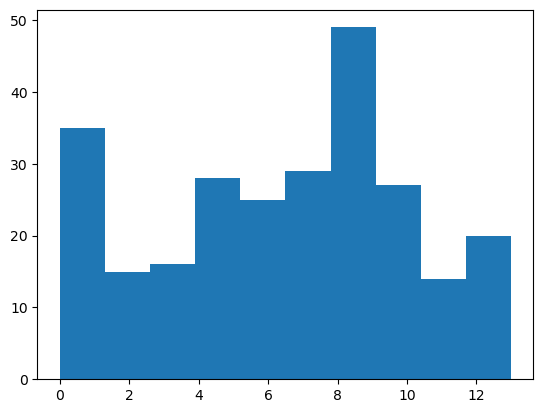

In [72]:
print(plt.hist(trial_scored_df['health_score'].values))

In [56]:
#  Setup tracking
approved_count = 0
rejected_count = 0
decision_records = []
count = 0

# Evaluate each post one-by-one
for i, row in trial_scored_df.iterrows():
    score = row['health_score']

    # Update threshold based on scores seen so far
    threshold = get_dynamic_threshold(
        historical_scores=trial_scored_df['health_score'].values,
        approved_count=approved_count,
        rejected_count=rejected_count,
        max_posts=50,
        max_potential_posts=300
    )

    # Make decision
    approve = should_approve(score, threshold)

    row_data = row.copy()
    row_data['approved'] = approve
    row_data['threshold'] = threshold
    row_data['approved_count'] = approved_count
    row_data['rejected_count'] = rejected_count

    decision_records.append(row_data)

    if approve:
        approved_count += 1
        print(f"({count}): score {score}, thresh: {threshold:.2f} → Approved")
    else:
        rejected_count += 1
        print(f"({count}): score {score}, thresh: {threshold:.2f} → Rejected")

    count += 1

# Final results
result_df = pd.DataFrame(decision_records).reset_index(drop=True)

print(f"\n{result_df['approved'].sum()} posts approved out of {len(result_df)} total.")


(0): score 8.0, thresh: 10.00 → Rejected
(1): score 6.0, thresh: 10.00 → Rejected
(2): score 9.0, thresh: 10.00 → Rejected
(3): score 3.0, thresh: 10.00 → Rejected
(4): score 8.0, thresh: 10.00 → Rejected
(5): score 11.0, thresh: 10.00 → Approved
(6): score 12.0, thresh: 10.00 → Approved
(7): score 5.0, thresh: 10.00 → Rejected
(8): score 6.0, thresh: 10.00 → Rejected
(9): score 0.0, thresh: 10.00 → Rejected
(10): score 10.0, thresh: 10.00 → Approved
(11): score 10.0, thresh: 10.00 → Approved
(12): score 9.0, thresh: 10.00 → Rejected
(13): score 10.0, thresh: 10.00 → Approved
(14): score 1.0, thresh: 10.00 → Rejected
(15): score 12.0, thresh: 10.00 → Approved
(16): score 13.0, thresh: 10.00 → Approved
(17): score 11.0, thresh: 10.00 → Approved
(18): score 3.0, thresh: 10.00 → Rejected
(19): score 1.0, thresh: 10.00 → Rejected
(20): score 11.0, thresh: 10.00 → Approved
(21): score 10.0, thresh: 10.00 → Approved
(22): score 8.0, thresh: 10.00 → Rejected
(23): score 1.0, thresh: 10.00 → R

In [57]:
result_df.head(10)


,feed_id,cash_flow_and_financing,cost_management,operational_milestones,partnership_and_strategic_initiatives,project_development,revenue_and_profitability,primary_stock,date,health_score,approved,threshold,approved_count,rejected_count
0,003539d8a0d4b097a2cf22da6787a741,1.0,1.0,1.0,1.0,2.0,2.0,PL8,2025-04-16,8.0,False,10.0,0,0
1,00a4a0e6915986c081d64b7c1bfeb366,1.0,1.0,0.0,2.0,2.0,0.0,MEC,2025-04-16,6.0,False,10.0,0,1
2,0255b0096fbc20ae2ac246d25032c567,3.0,1.0,1.0,2.0,2.0,NaN,CTD,2025-04-16,9.0,False,10.0,0,2
3,02f554be04a92384937fa7351851f7be,1.0,NaN,NaN,2.0,NaN,NaN,DM1,2025-04-16,3.0,False,10.0,0,3
4,036d7f61197aedd6d7dcecfc4ad9c184,3.0,1.0,NaN,2.0,2.0,NaN,S32,2025-04-16,8.0,False,10.0,0,4
5,053e245601e5b60e130bcc305746e4e8,1.0,1.0,2.0,2.0,2.0,3.0,SHN,2025-04-16,11.0,True,10.0,0,5
6,05cc606a9c9fc08c73d78277debec5e4,2.0,2.0,2.0,2.0,2.0,2.0,ALA,2025-04-16,12.0,True,10.0,1,5
7,05e9052b1d4b582867276f53a6a1a243,NaN,NaN,1.0,2.0,2.0,NaN,COB,2025-04-16,5.0,False,10.0,2,5
8,06e6fa1400513a277adabd2465364187,0.0,1.0,1.0,2.0,2.0,0.0,COG,2025-04-16,6.0,False,10.0,2,6
9,07bfe492dea1a4143adbb6b1d255915e,0.0,NaN,NaN,NaN,NaN,NaN,M2M,2025-04-16,0.0,False,10.0,2,7


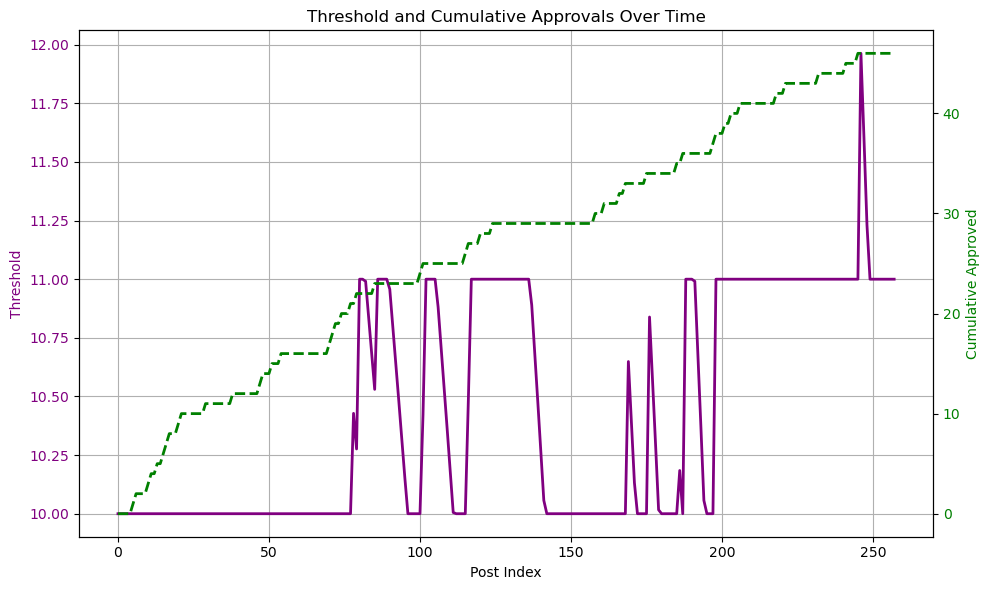

In [58]:
import matplotlib.pyplot as plt

x = range(len(result_df))  # index = post number
thresholds = result_df['threshold']
cumulative_approved = result_df['approved'].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot threshold
ax1.plot(x, thresholds, color='purple', label='Threshold', linewidth=2)
ax1.set_xlabel('Post Index')
ax1.set_ylabel('Threshold', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot approved count on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, cumulative_approved, color='green', label='Approved Count', linewidth=2, linestyle='--')
ax2.set_ylabel('Cumulative Approved', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Threshold and Cumulative Approvals Over Time')
ax1.grid(True)
fig.tight_layout()
plt.show()


In [59]:
# # Reverse the score_maps: value → key
# reverse_maps = {col: {v: k for k, v in mapping.items()} for col, mapping in score_maps.items()}

# # Make a copy to avoid mutating result_df
# decoded_df = result_df.copy()

# # Apply reverse mapping to each column
# for col, reverse_map in reverse_maps.items():
#     if col in decoded_df.columns:
#         decoded_df[col] = decoded_df[col].map(reverse_map)

# decoded_df.to_csv('approved_posts_2025_04_14.csv')